In [36]:
import json
import itertools
import re
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.core.common import flatten  
from random import sample
from collections import Counter
from functools import reduce
from matplotlib.lines import Line2D

from matplotlib.pyplot import axvline, text
################  DATA IMPORT, CLEANING AND MUNGING  ####################
################  DATA IMPORT, CLEANING AND MUNGING  ####################
################  DATA IMPORT, CLEANING AND MUNGING  ####################
# Multiple string replace function #####################

def multReplaceStr (stri):
    lis_=[]
    in_=['\n', 'Type', 'Method', 'Location']
    out_=[' ', '', '::', '::']
    for ele in stri:
        ele1 = ele.replace(in_[0], out_[0])
        ele2 = ele1.replace(in_[1], out_[1])
        ele3 = ele2.replace(in_[2], out_[2])
        ele4 = ele3.replace(in_[3], out_[3])
        ele5 = ele4.split('::')
        lis_.append(ele5)    
    return lis_   
####################################
## read in Selenium scrape data in json format  

with open('groupOverview_l.json') as f:
    data = json.loads("[" + 
        f.read().replace("][", "],\n[") + 
    "]")
    #print(data[0][2])
    group = pd.Series(flatten([data[i][0] for i in range(len(data))]))
    OverviewText = pd.Series(flatten([data[i][1] for i in range(len(data))]))
    BGA = pd.Series([data[i][2] for i in range(len(data))])
    TypeNames_= []
    Method_ = []
    Location_ = []
    OverallScore_ = []
    for ind in range(len(data)):
        TML = multReplaceStr(data[ind][3])
        TypeNames_.append([x.strip(' ') for x in (TML[i][0] for i in range(len(TML)))])
        TypeNames = pd.Series(TypeNames_)
        Method_.append([x.upper().strip(' ').replace('JIGS', 'JIG').replace('TRAPS (UNSPECIFIED)', 'TRAPS') for x in (TML[i][1] for i in range(len(TML)))]) # method strings to uppercase as there are some case differences between same methods. Also fix some plural terms.
        Method = pd.Series(Method_)
        Location_.append([x.strip(' ') for x in (TML[i][2] for i in range(len(TML)))])
        Location = pd.Series(Location_)
        OverallScore_.append([i.replace('Overall Score: ', '') for i in data[ind][4]])
        OverallScore = pd.Series(OverallScore_)
# len(list(flatten(BGA))) #1697
# len(list(flatten(TypeNames))) #2341
# len(list(flatten(Method))) #2341
# len(list(flatten(Location))) #2341
# len(list(flatten(OverallScore))) #1687


In [37]:
################  EDA FOR MEANS  ####################
################  EDA FOR MEANS  ####################
################  EDA FOR MEANS  ####################
## Calculate Mean of OverallScore for all groups
# remove blank strings and flatten into single list

OverallScore_c =[str for str in list(flatten(OverallScore)) if str != ''] 
# convert all strings to float and mean

np.mean([float(x) for x in OverallScore_c])
## 3.05157338902148 
## len(OverallScore_c)
## 1676

np.sum([float(x) for x in OverallScore_c]) #5114.437
# len(list(flatten(OverallScore)))
# 1687
## Calculate mean of OverallScore by groups

lis_=[]
NestRedo=[]

for li in OverallScore:
    byNest = [str for str in list(flatten(li)) if str != ''] 
    NestRedo.append(byNest)
    lis_.append(np.mean([float(x) for x in byNest]))
    meanByGroup = pd.Series(lis_)

meanByGroup

np.mean(meanByGroup)
## 3.2972108307693793
## len(list(flatten(NestRedo))) # 1676


3.2972108307693793

In [38]:
################### CREATE DATAFRAMES ####################
################### CREATE DATAFRAMES ####################
################### CREATE DATAFRAMES ####################
# CREATE DATAFRAME
## distribution of BEST CHOICE’,’GOOD ALTERNATIVE’,'AVOID' for each group

best_l=[]
good_l=[]
avoid_l=[]

for x in BGA:
    best_l.append(x.count('BEST CHOICE'))
    best = pd.Series(best_l)
    good_l.append(x.count('GOOD ALTERNATIVE'))
    good = pd.Series(good_l)
    avoid_l.append(x.count('AVOID'))
    avoid = pd.Series(avoid_l)

numScored = pd.Series([len(x) for x in BGA ])
numTotal = pd.Series([len(x) for x in Location])
overText = pd.Series([x.strip() for x in OverviewText])

simple_df = pd.concat([group, best, good, avoid, meanByGroup, numScored, numTotal-numScored, numTotal, overText], axis=1, keys=['group', 'best', 'good', 'avoid', 'meanGroupScore', 'numScored', 'numUnScored', 'numTotal', 'overviewText'])
# save to csv

simple_df.to_csv('simple_df.csv')


In [39]:
##  SECOND DATAFRAME WITH INDIVIDUAL SCORES, TYPENAMES, METHOD, LOCATION
# expected number of rows for detailed dataframe
# len(list(flatten(BGA))) #1697
# len(list(flatten(TypeNames))) #2341
# len(list(flatten(Method))) #2341
# len(list(flatten(Location))) #2341
# len(list(flatten(OverallScore))) #1687

detail_df=[]

for i in range(len(group)):
    df_ = pd.concat([pd.Series(np.repeat(group[i], [len(Location[i])])), pd.Series(BGA[i]), pd.Series(TypeNames[i]), pd.Series(Method[i]), pd.Series(Location[i]), pd.Series(OverallScore[i])], axis=1, keys=['group', 'recommend', 'typeNames', 'method', 'location', 'overallScore' ] )
    detail_df.append(df_)

detail_df = pd.concat(detail_df, axis=0)
# fill in nan in overallScore column for sources without a score, these are ECO-certified sources that will be assigned a score of 10 for lack of having a score

detail_df['overallScore']= detail_df['overallScore'].fillna(10)
# coerce overallScore column to float

detail_df['overallScore']= pd.to_numeric(detail_df['overallScore'], errors='coerce')
# save to csv

detail_df.to_csv('detail_df.csv')


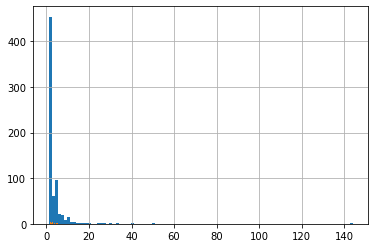

In [40]:
################  EDA FOR FREQUENCY DISTRIBUTIONS  ####################
################  EDA FOR FREQUENCY DISTRIBUTIONS  ####################
################  EDA FOR FREQUENCY DISTRIBUTIONS  ####################
# frequency distributions 

Counter(detail_df['recommend'])

detail_df['recommend'].value_counts()
# Counter({'BEST CHOICE': 305, 'GOOD ALTERNATIVE': 769, nan: 644, 'AVOID': 623})
# Counter(detail_df['method'])
# Counter(detail_df['location'])
# frequency distribution of locations

detail_df['location'].value_counts().hist(bins=100)
# frequency distribution of scores by group

simple_df['meanGroupScore'].hist(bins=100)


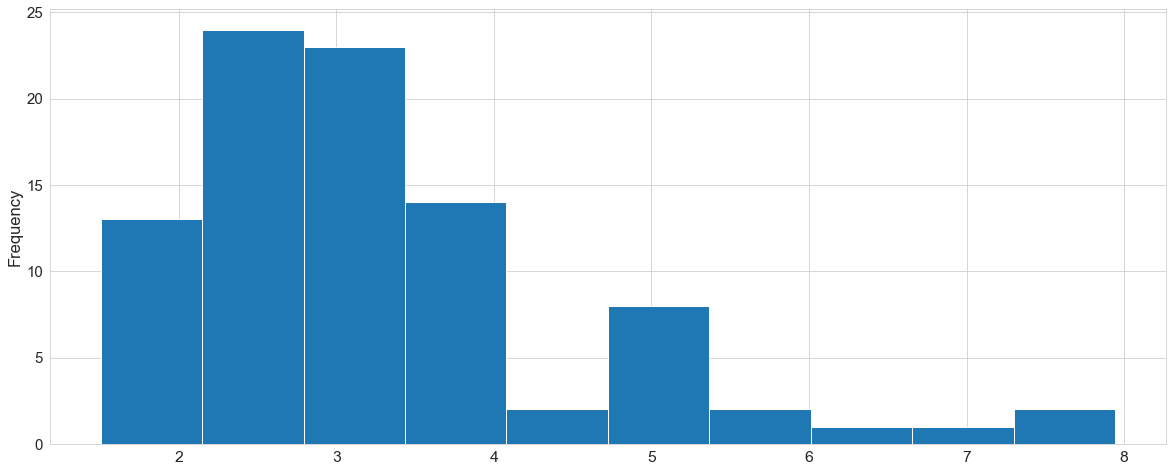

In [41]:
################### CREATE VISUALIZATIONS ####################
################### CREATE VISUALIZATIONS ####################
################### CREATE VISUALIZATIONS ####################
#########  SET FONT SIZES AND PARAMS FOR GRAPHS  #########

size=15

params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size*1.0,
          'axes.titlesize': size*2,
          'axes.labelsize': size*1.1,
          'xtick.labelsize': size*1.05,
          'ytick.labelsize': size*1.0,
          'axes.titlepad': 25,
          'figure.titlesize': size*2,
          'legend.fontsize': size}

plt.rcParams.update(params)

sns.set_style("whitegrid")
## Plotting mean overall scores by groups

meanByGroup.plot.hist()


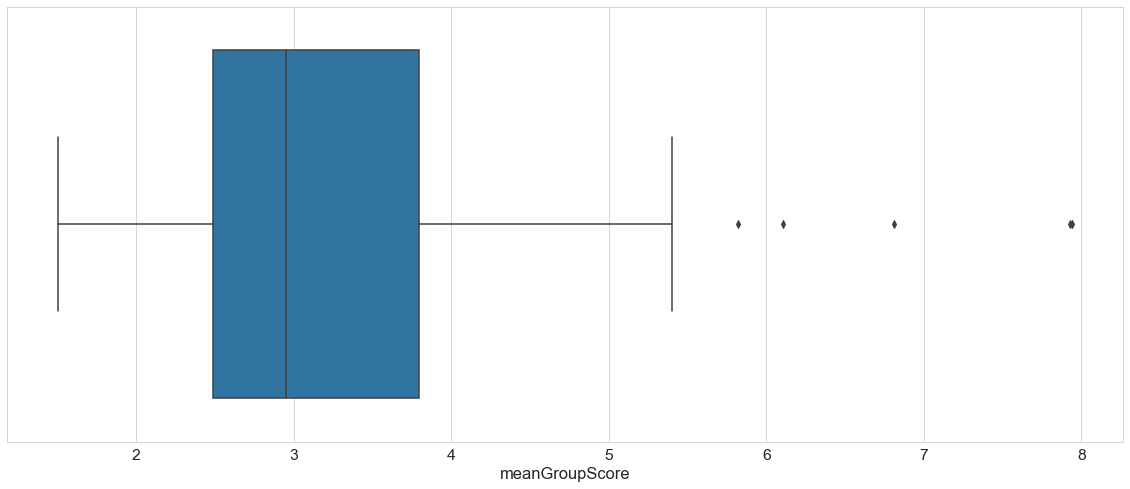

In [42]:
sns.boxplot(simple_df['meanGroupScore'])


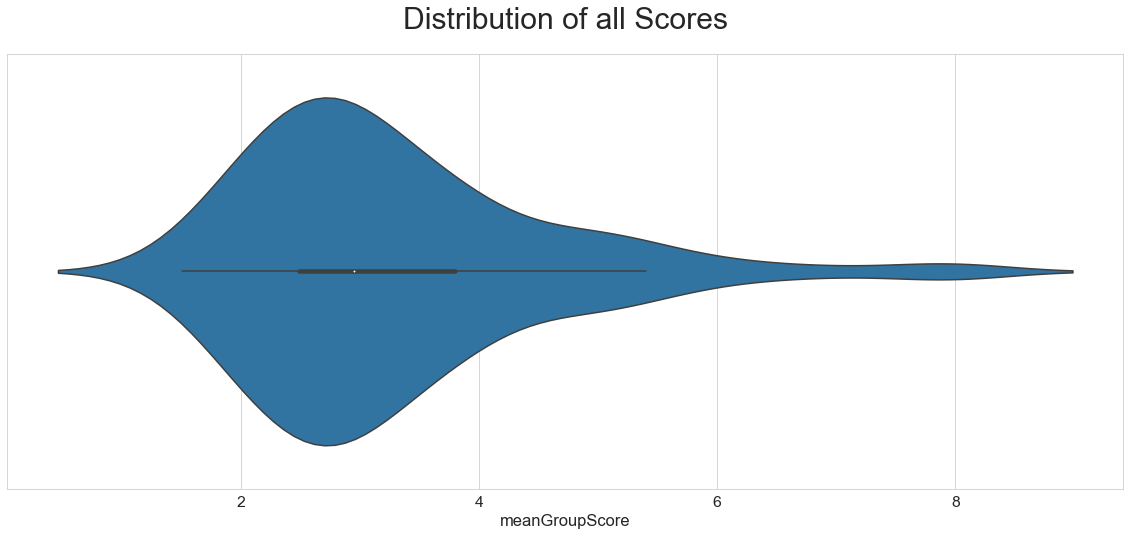

In [43]:
#violin plot

plt.title('Distribution of all Scores')
sns.violinplot(simple_df['meanGroupScore'])


In [44]:
## checking out mean scores for various groupings

detail_df.groupby('method').agg({'overallScore':'mean'})
detail_df.groupby('location').agg({'overallScore':'mean'})

detail_df.groupby('recommend').agg({'overallScore':'mean'})
#### IMPORTANT: Note that assigning scores of 10 for ECO-certified sources skews data. Will need to change this for further analysis


overallScore
recommend                     
AVOID                 1.991246
BEST CHOICE           5.080902
GOOD ALTERNATIVE      3.190265

Text(2.95, 2.73, 'Mean')

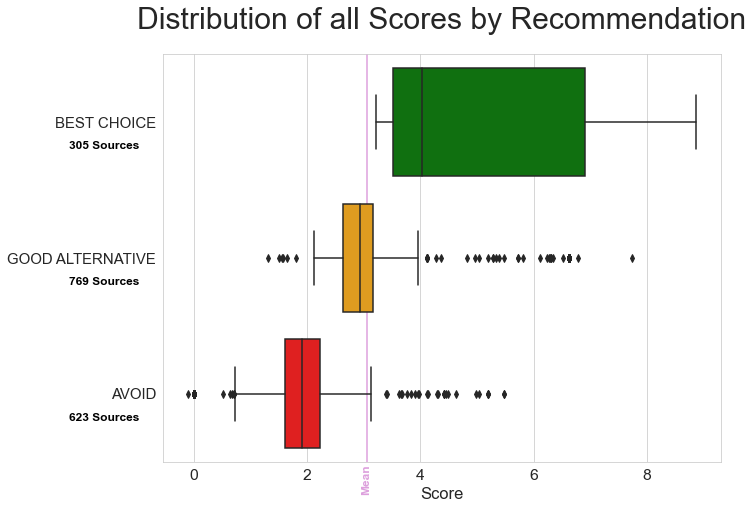

In [45]:
## Distribution of recommendations box plot

plt.figure(figsize=(10, 7.5))
axvline(x=np.mean([float(x) for x in OverallScore_c]), color='plum',zorder=0)
plt.title('Distribution of all Scores by Recommendation')
my_pal = {"BEST CHOICE": "g", "GOOD ALTERNATIVE": "orange", "AVOID":"r"}
p1 = sns.boxplot(y= detail_df.loc[(detail_df['overallScore'] != 10), 'recommend'],   x=detail_df.loc[(detail_df['overallScore'] != 10), 'overallScore'], data=detail_df, palette=my_pal, zorder=10)
plt.xlabel('Score')
plt.ylabel('')
p1.text(-2.2, 0+0.2, "305 Sources", horizontalalignment='left', size='large', color='black', weight='semibold')
p1.text(-2.2, 1+0.2, "769 Sources", horizontalalignment='left', size='large', color='black', weight='semibold')
p1.text(-2.2, 2+0.2, "623 Sources", horizontalalignment='left', size='large', color='black', weight='semibold')
p1.text(2.95, 2.73, "Mean", horizontalalignment='left', size=12, color='plum', weight='semibold', rotation='vertical')


Text(2.95, 2.73, 'Mean')

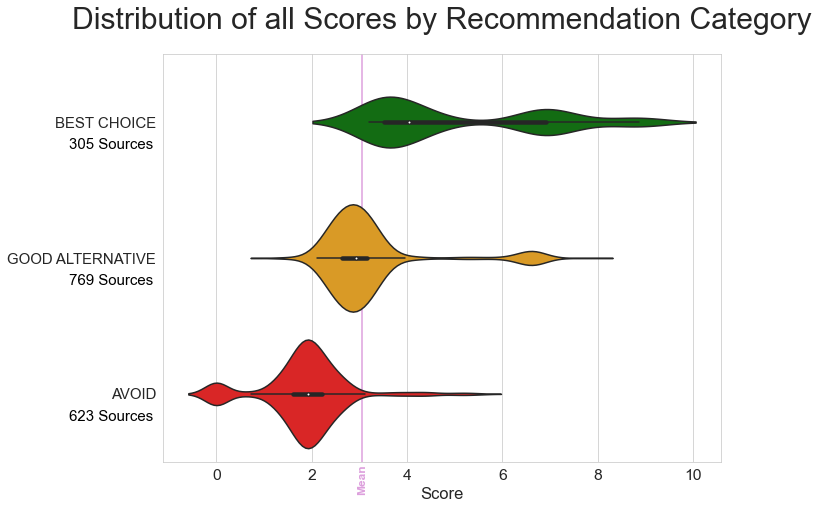

In [46]:
## Distribution of recommendations violin plot, without or with swarm overlay

plt.figure(figsize=(10, 7.5))
axvline(x=np.mean([float(x) for x in OverallScore_c]), color='plum',zorder=0)
plt.title('Distribution of all Scores by Recommendation Category')
my_pal = {"BEST CHOICE": "g", "GOOD ALTERNATIVE": "orange", "AVOID":"r"}

p1 = sns.violinplot(y= detail_df.loc[(detail_df['overallScore'] != 10), 'recommend'],   x=detail_df.loc[(detail_df['overallScore'] != 10), 'overallScore'], data=detail_df, palette=my_pal, saturation =0.7, zorder=5)
#p1 = sns.swarmplot(y= detail_df.loc[(detail_df['overallScore'] != 10), 'recommend'],   x=detail_df.loc[(detail_df['overallScore'] != 10), 'overallScore'], data=detail_df, color='gray', edgecolor='black', zorder=10)

plt.xlabel('Score')
plt.ylabel('')
p1.text(-3.1, 0+0.2, "305 Sources", horizontalalignment='left', size=15, color='black')
p1.text(-3.1, 1+0.2, "769 Sources", horizontalalignment='left', size=15, color='black')
p1.text(-3.1, 2+0.2, "623 Sources", horizontalalignment='left', size=15, color='black')
p1.text(2.95, 2.73, "Mean", horizontalalignment='left', size=12, color='plum', weight='semibold', rotation='vertical')


Text(2.95, 2.73, 'Mean')

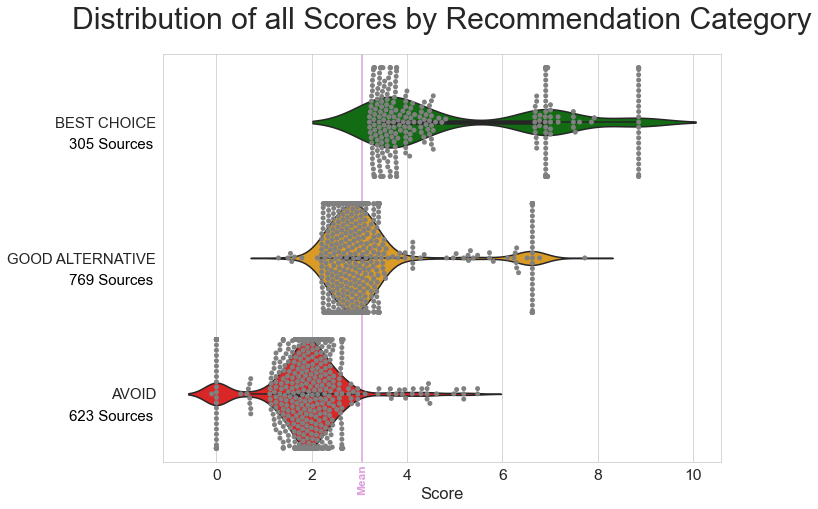

In [47]:
## Distribution of recommendations violin plot, without or with swarm overlay

plt.figure(figsize=(10, 7.5))
axvline(x=np.mean([float(x) for x in OverallScore_c]), color='plum',zorder=0)
plt.title('Distribution of all Scores by Recommendation Category')
my_pal = {"BEST CHOICE": "g", "GOOD ALTERNATIVE": "orange", "AVOID":"r"}
p1 = sns.violinplot(y= detail_df.loc[(detail_df['overallScore'] != 10), 'recommend'],   x=detail_df.loc[(detail_df['overallScore'] != 10), 'overallScore'], data=detail_df, palette=my_pal, saturation =0.7, zorder=5)
p1 = sns.swarmplot(y= detail_df.loc[(detail_df['overallScore'] != 10), 'recommend'],   x=detail_df.loc[(detail_df['overallScore'] != 10), 'overallScore'], data=detail_df, color='gray', edgecolor='black', zorder=10)
plt.xlabel('Score')
plt.ylabel('')
p1.text(-3.1, 0+0.2, "305 Sources", horizontalalignment='left', size=15, color='black')
p1.text(-3.1, 1+0.2, "769 Sources", horizontalalignment='left', size=15, color='black')
p1.text(-3.1, 2+0.2, "623 Sources", horizontalalignment='left', size=15, color='black')
p1.text(2.95, 2.73, "Mean", horizontalalignment='left', size=12, color='plum', weight='semibold', rotation='vertical')


In [48]:
# based on distribution, want to know what sources have scores higher than 6:

scorehigher6_df = detail_df.loc[((detail_df['overallScore'] > 6) & (detail_df['overallScore'] != 10 ))]
# 172 sources
# save csv table

scorehigher6_df.to_csv('scorehigher6_df.csv')
#summary of sources with score higher than 6

scorehigher6count_df = scorehigher6_df.groupby('group').agg({'group': 'count'})

scorehigher6count_df.columns = ["Num_Sources"]
# save csv table

scorehigher6count_df.to_csv('scorehigher6count_df.csv')


In [49]:
scorehigher6_df


group         recommend  \
0   Abalone       BEST CHOICE   
1   Abalone       BEST CHOICE   
2   Abalone       BEST CHOICE   
3   Abalone       BEST CHOICE   
4   Abalone  GOOD ALTERNATIVE   
..      ...               ...   
16    Trout  GOOD ALTERNATIVE   
18    Trout  GOOD ALTERNATIVE   
23    Trout  GOOD ALTERNATIVE   
0    Turbot       BEST CHOICE   
2    Turbot  GOOD ALTERNATIVE   

                                           typeNames  \
0                                      Abalone Awabi   
1                                      Abalone Awabi   
2                                      Abalone Awabi   
3                                      Abalone Awabi   
4                                      Abalone Awabi   
..                                               ...   
16  Trout, Rainbow Steelhead Trout, Steelhead, Trout   
18  Trout, Rainbow Steelhead Trout, Steelhead, Trout   
23  Trout, Rainbow Steelhead Trout, Steelhead, Trout   
0      Turbot                         Hirame, Turbot   
2      Turbot                         Hirame, Turbot   

                                               method   location  overallScore  
0                             INDOOR FLOWTHROUGH TANK  Worldwide          6.95  
1                             ENCLOSED BOTTOM CULTURE  Worldwide          6.95  
2                            OUTDOOR FLOWTHROUGH TANK  Worldwide          6.95  
3                                  OFF-BOTTOM CULTURE  Worldwide          6.95  
4                                 OPEN BOTTOM CULTURE  Worldwide          6.24  
..                                                ...        ...           ...  
16                                           RACEWAYS     Canada          6.30  
18                                              TANKS     Canada          6.30  
23  INDOOR RECIRCULATING TANK (WITHOUT WASTEWATER ...  Worldwide          6.63  
0   INDOOR RECIRCULATING TANK (WITH WASTEWATER TRE...  Worldwide          6.91  
2   INDOOR RECIRCULATING TANK (WITHOUT WASTEWATER ...  Worldwide          6.63  

[172 rows x 6 columns]

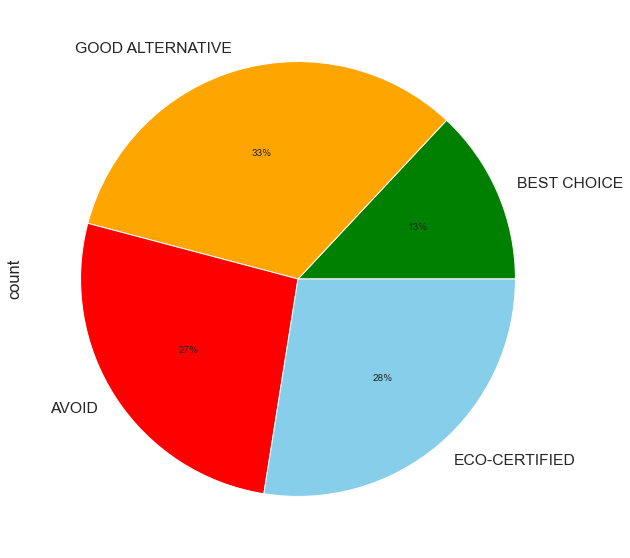

In [50]:
## Recommendations pie chart
# Counter({'BEST CHOICE': 305, 'GOOD ALTERNATIVE': 769, nan: 644, 'AVOID': 623})

recs= pd.DataFrame([pd.Series({'BEST CHOICE': 305, 'GOOD ALTERNATIVE': 769, 'AVOID': 623, 'ECO-CERTIFIED': 644})]).T
recs.columns= ['count']
recs.plot.pie(y= 'count', figsize=(10,10), autopct='%1.0f%%', legend=False, colors = ['green', 'orange', 'red', 'skyblue'])
plt.show()


([<matplotlib.patches.Wedge at 0x1281d6dc0>,
 [Text(8.799492862917393, 0.09447409944451664, 'Abalone'),
  Text(8.78535241727824, 0.5075262596392336, 'Amberjack'),
  Text(8.733015628824186, 1.0837149194841402, 'Anchovy'),
  Text(8.682321017955347, 1.4343297184297714, 'Arctic Char'),
  Text(8.664364506595804, 1.539086643708817, 'Barnacle'),
  Text(8.640701527925273, 1.6668164581950418, 'Bass'),
  Text(8.610309099098222, 1.817299429919671, 'Bluefish'),
  Text(8.600429921830054, 1.8634927313220955, 'Bowfin'),
  Text(8.571985245259198, 1.9902434411545324, 'Bream'),
  Text(8.535961105282915, 2.139478443242019, 'Brill'),
  Text(8.509498769550644, 2.2424162617623162, 'Butterfish'),
  Text(8.484934480994944, 2.33364240045965, 'Cabezon'),
  Text(8.452854206279989, 2.4472956027776274, 'Capelin'),
  Text(8.128444165100243, 3.371705125726124, 'Carp'),
  Text(7.633785010082798, 4.377822109203981, 'Catfish'),
  Text(7.303372596705176, 4.909251339430067, 'Clams'),
  Text(7.029453214302518, 5.294033198

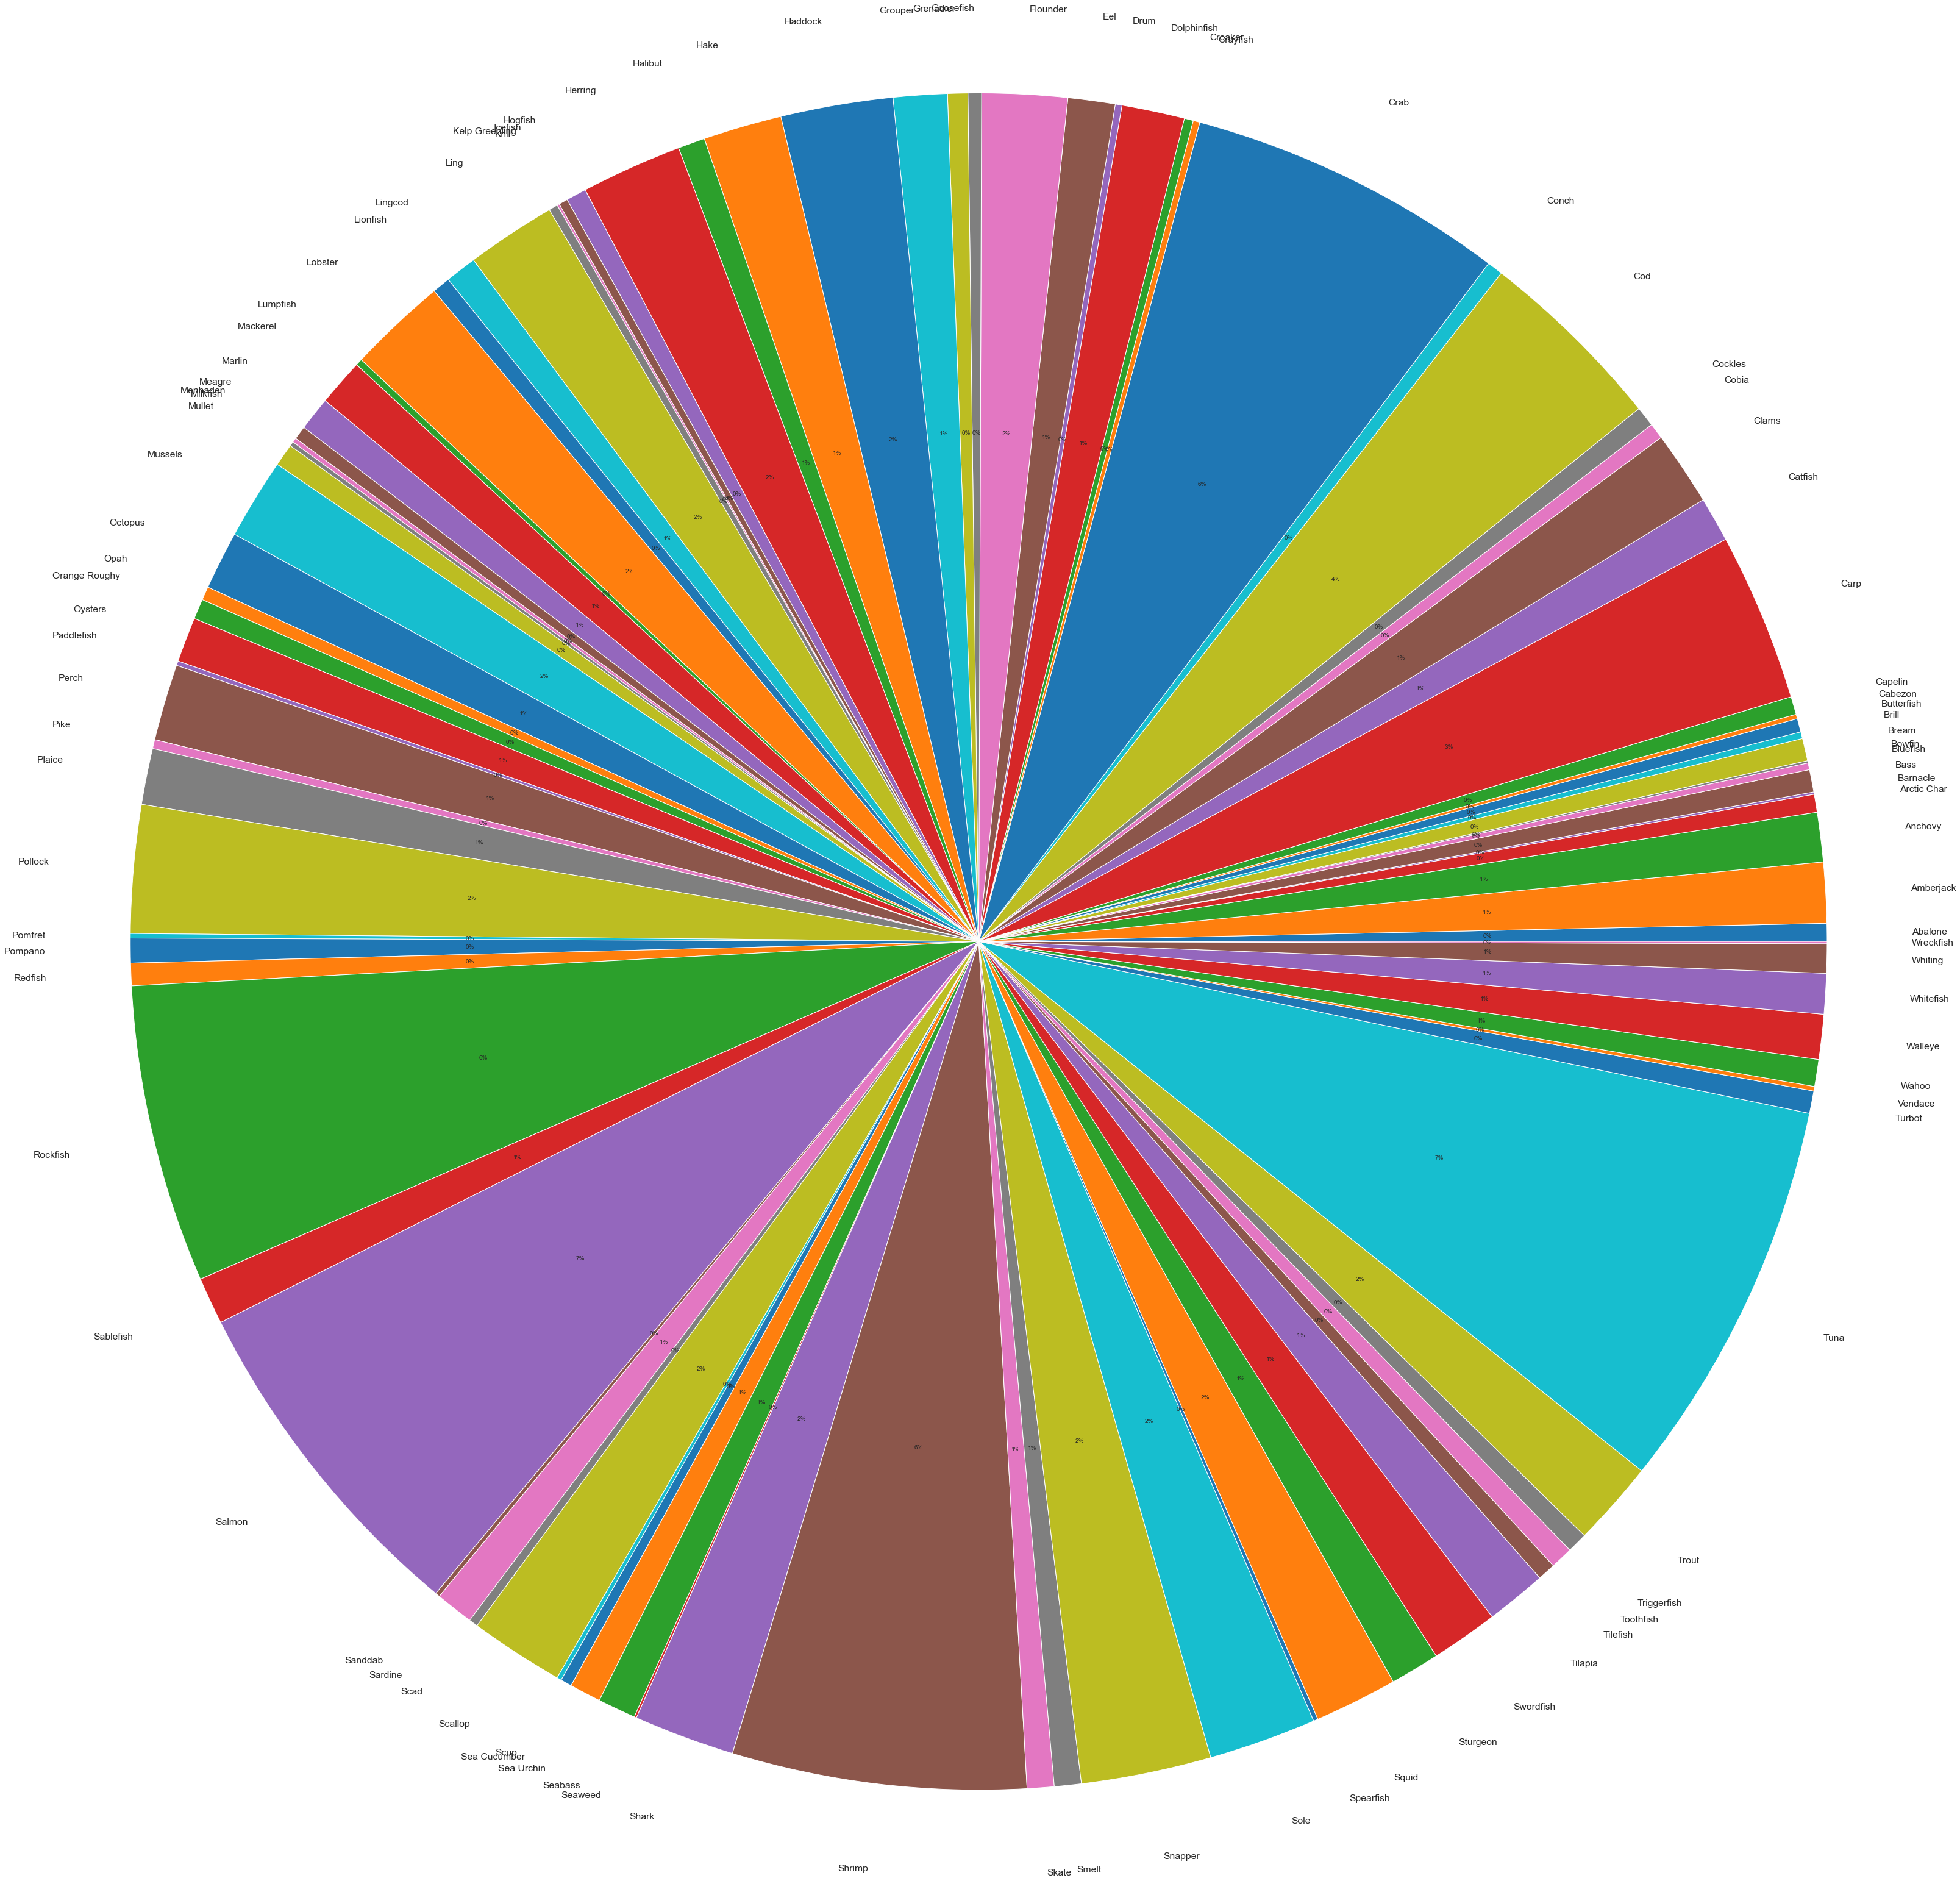

In [51]:
## Groups pie chart
# matplotlib plotting, pandas plotting used in pie plot above didnt work as didnt allow groups labeling

plt.pie(simple_df['numTotal'], labels=simple_df['group'], autopct='%1.0f%%', radius=8)


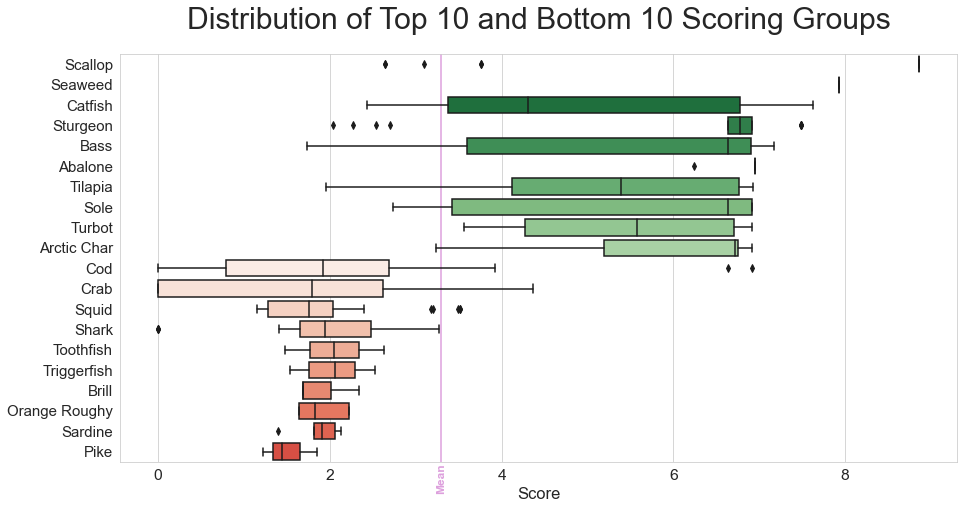

In [52]:
# Top/Bottom 10 groups boxplot
# make dataframes with high or low groups 

low10_groups = simple_df.loc[(simple_df['meanGroupScore'] <2.06 ), 'group']
high10_groups = simple_df.loc[(simple_df['meanGroupScore'] >4.9 ), 'group']
low10_groups.tolist()
low10_df=[]

for grp in low10_groups.tolist():
    df_ = detail_df.loc[(detail_df['group'] == grp ), ('group', 'recommend', 'typeNames', 'method', 'location', 'overallScore')]
    low10_df.append(df_)

low10_df = pd.concat(low10_df, axis=0)
high10_groups.tolist()
high10_df=[]

for grp in high10_groups.tolist():
    df_ = detail_df.loc[(detail_df['group'] == grp ), ('group', 'recommend', 'typeNames', 'method', 'location', 'overallScore')]
    high10_df.append(df_)

high10_df = pd.concat(high10_df, axis=0)
# combine both high and low dataframes together to simplify plotting

highlow_df= pd.concat([high10_df, low10_df], axis=0).sort_values('overallScore', ascending = False)
# make custom color palette

r_pal = sns.color_palette("Reds",15)
g_pal = sns.color_palette("Greens_r",15)
pal=g_pal.as_hex()[:10]+r_pal.as_hex()[:10]
plt.figure(figsize=(15, 7.5))
plt.title('Distribution of Top 10 and Bottom 10 Scoring Groups')
p1 = sns.boxplot(y= highlow_df.loc[(highlow_df['overallScore'] != 10) ,'group'], x= highlow_df.loc[(highlow_df['overallScore'] != 10) ,'overallScore'], data=highlow_df, zorder=10, palette=pal)
plt.xlabel('Score')
plt.ylabel('')
axvline(x=np.mean(meanByGroup), color='plum',zorder=0)
p1.text(3.24, 21, "Mean", horizontalalignment='left', size=12, color='plum', weight='semibold', rotation='vertical')
plt.show()


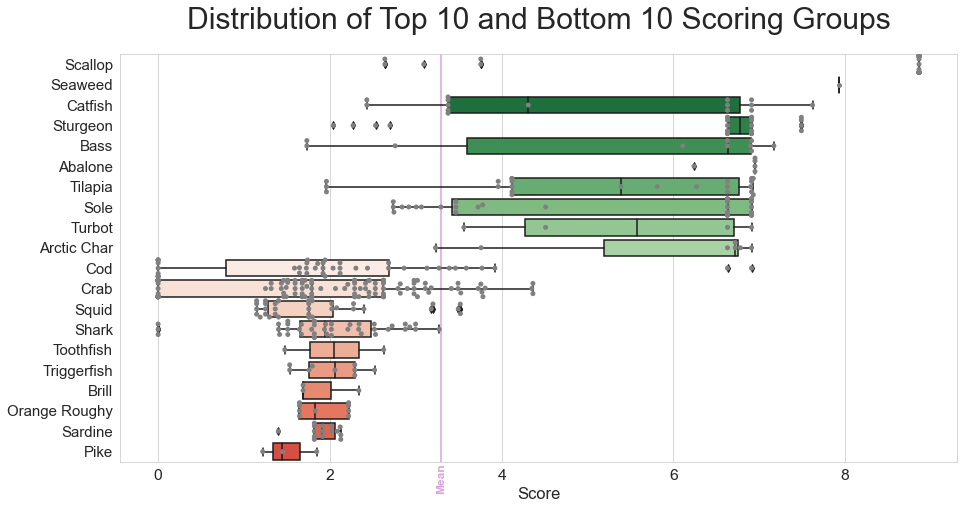

In [53]:
# boxplot with swarm

plt.figure(figsize=(15, 7.5))
plt.title('Distribution of Top 10 and Bottom 10 Scoring Groups')
p1 = sns.boxplot(y= highlow_df.loc[(highlow_df['overallScore'] != 10) ,'group'], x= highlow_df.loc[(highlow_df['overallScore'] != 10) ,'overallScore'], data=highlow_df, zorder=5, palette=pal)
p1 = sns.swarmplot(y= highlow_df.loc[(highlow_df['overallScore'] != 10) ,'group'], x= highlow_df.loc[(highlow_df['overallScore'] != 10) ,'overallScore'], data=highlow_df, zorder=10, color='gray', edgecolor='black')
plt.xlabel('Score')
plt.ylabel('')
axvline(x=np.mean(meanByGroup), color='plum',zorder=0)
p1.text(3.24, 21, "Mean", horizontalalignment='left', size=12, color='plum', weight='semibold', rotation='vertical')
plt.show()


In [54]:
##### further investigate the top 10 and bottom 10 scoring groups. check into methods and locations for each  ######
##### further investigate the top 10 and bottom 10 scoring groups. check into methods and locations for each  ######

highlow_notECO_df = highlow_df.loc[(highlow_df['overallScore'] != 10) ]
highlow_df['method'].value_counts()

highlow_df['location'].value_counts()
# find most common location for each method:

most_common_location = highlow_notECO_df.groupby(['method'])['location'].agg(lambda x: x.value_counts().index[0]).reset_index()

highest_lowest_location_counts_ByMethod = highlow_notECO_df.groupby(['group','method','location']).agg(loc_count=('location','count'))
# save to csv

highest_lowest_location_counts_ByMethod.to_csv('highest_lowest_location_counts_ByMethod.csv')
# location counts total

total_locations_per_method = highlow_notECO_df.groupby(['method']).agg({'location':'count'})
# location with max counts by method

group_highest_loc_count = highest_lowest_location_counts_ByMethod.groupby(['group']).agg({'loc_count':'max'})


In [55]:
highest_lowest_location_counts_ByMethod


loc_count
group       method                                             location                                                     
Abalone     ENCLOSED BOTTOM CULTURE                            Worldwide                                                   1
            INDOOR FLOWTHROUGH TANK                            Worldwide                                                   1
            OFF-BOTTOM CULTURE                                 Worldwide                                                   1
            OPEN BOTTOM CULTURE                                Worldwide                                                   1
            OUTDOOR FLOWTHROUGH TANK                           Worldwide                                                   1
...                                                                                                                      ...
Triggerfish SET LONGLINES                                      U.S. - Puerto Rico, Western Central Atlantic Ocean          1
Turbot      BOTTOM TRAWLS                                      U.S. - Alaska, Northeast Pacific Ocean: Bering ...          1
            INDOOR RECIRCULATING TANK (WITH WASTEWATER TREA... Worldwide                                                   1
            INDOOR RECIRCULATING TANK (WITHOUT WASTEWATER T... Worldwide                                                   1
            SET LONGLINES                                      U.S. - Alaska, Northeast Pacific Ocean: Bering ...          1

[286 rows x 1 columns]

In [56]:
total_locations_per_method


location
method                                                      
BARRIERS, FENCES, WEIRS, CORRALS, ETC.                     4
BEACH SEINES                                               1
BEAM TRAWLS                                                1
BOAT SEINES                                                5
BOTTOM CULTURE                                            13
BOTTOM TRAWLS                                             47
CAST NETS                                                  5
COMBINED GILLNETS - TRAMMEL NETS                           1
CRAB RINGS                                                 5
DIVING                                                     4
DRIFT GILLNETS                                             4
DRIFTING LONGLINES                                        24
ENCLOSED BOTTOM CULTURE                                    1
FLOATING OBJECT PURSE SEINE (FAD)                          1
FRESHWATER NET PEN                                         6
FYKE NETS                                                  1
GILLNETS AND ENTANGLING NETS (UNSPECIFIED)                10
HANDLINES                                                  2
HANDLINES AND HAND-OPERATED POLE-AND-LINES                 4
INDOOR FLOWTHROUGH TANK                                    1
INDOOR RECIRCULATING TANK (WITH WASTEWATER TREA...        27
INDOOR RECIRCULATING TANK (WITHOUT WASTEWATER T...        27
INTENSIVE POND                                             1
JIG                                                       16
LONGLINE (DEEP-SET)                                        8
LONGLINE (SHALLOW-SET)                                     7
MARINE NET PEN                                             1
MIDWATER TRAWLS                                            9
OFF-BOTTOM CULTURE                                        15
OPEN BOTTOM CULTURE                                        1
OUTDOOR FLOWTHROUGH RACEWAY                                2
OUTDOOR FLOWTHROUGH TANK                                   1
PONDS                                                     14
POTS                                                      97
PURSE SEINES                                               6
RACEWAYS                                                   4
SCOOPNETS                                                  1
SET GILLNETS                                              20
SET LONGLINES                                             13
STATIONARY UNCOVERED POUND NETS                            3
TANKS                                                      3
TOWED DREDGES                                              4
TRAPS                                                     12
TROTLINE                                                   1
UNASSOCIATED PURSE SEINE (NON-FAD)                         7

In [57]:
group_highest_loc_count


loc_count
group                   
Abalone                1
Arctic Char            1
Bass                   2
Brill                  1
Catfish                3
Cod                    1
Crab                  10
Orange Roughy          1
Pike                   1
Sardine                1
Scallop               13
Seaweed                1
Shark                  3
Sole                   9
Squid                  3
Sturgeon               7
Tilapia                6
Toothfish              1
Triggerfish            1
Turbot                 1

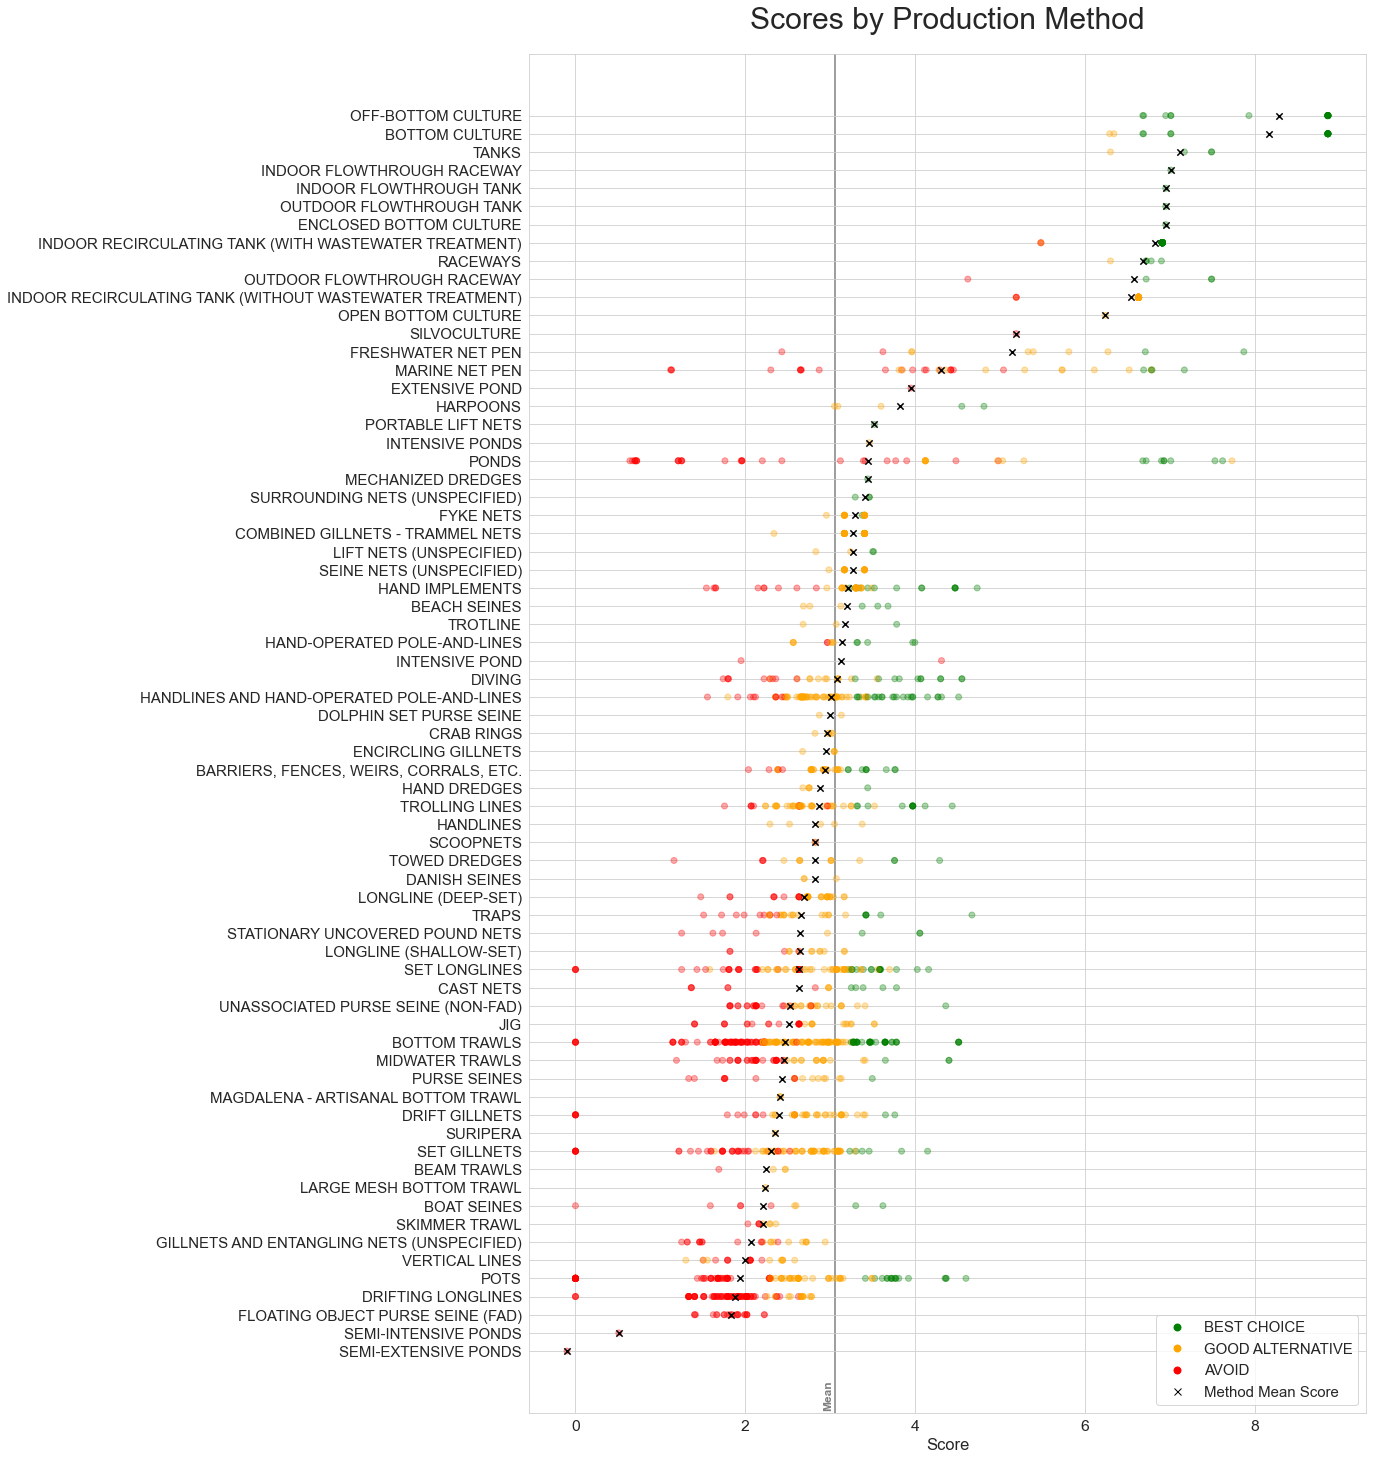

In [59]:
## Scores by Production method without Eco-cert.
# remove scores of 10 and reorder method column by mean overallScore for each grouped method:

sortS_detail_df= detail_df.loc[(detail_df['overallScore'] != 10)]

sortSmean_detail_df= sortS_detail_df.iloc[(sortS_detail_df.groupby('method')['overallScore'].transform('mean')).argsort()]
# get list of 69 methods ordered above by mean overallScore

grp=sortSmean_detail_df.groupby('method')
method_grp=[]

for key, values in grp:
    method_grp.append(key)
# create list of colors according to recommend column

cols = pltcolor(sortSmean_detail_df[ 'recommend'])
plt.figure(figsize=(15, 25))
plt.xlabel('Score')
plt.title('Scores by Production Method')
p1=plt.scatter(sortSmean_detail_df['overallScore'], sortSmean_detail_df['method'], c=cols, alpha=1/3, zorder=5)
p1=plt.scatter(sortSmean_detail_df.groupby('method').agg({'overallScore':'mean'}), method_grp, c='k', marker='x', label='Mean',s=40, zorder=10)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='BEST CHOICE', markerfacecolor='g', markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='GOOD ALTERNATIVE', markerfacecolor='orange', markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='AVOID', markerfacecolor='r', markersize=9),
                   Line2D([0], [0], marker='x', color='k', label='Method Mean Score', linewidth=0, markersize=7)]

p1=plt.legend(handles= legend_elements, loc= 'lower right')
axvline(x=np.mean([float(x) for x in OverallScore_c]), color='gray',zorder=0)
p1=text(2.92, -3.15, "Mean", horizontalalignment='left', size=12, color='gray', weight='semibold', rotation='vertical')


In [60]:
##### further expore methods by looking at most common location for each method #####
##### further expore methods by looking at most common location for each method #####

sortSmean_detail_df['location'].value_counts() # overall, most common location is 'Worldwide', not really helpful
# find most common location for each method:

most_common_location = sortSmean_detail_df.groupby(['method'])['location'].agg(lambda x: x.value_counts().index[0]).reset_index()

location_counts_ByMethod = sortSmean_detail_df.groupby(['method','location']).agg(loc_count=('location','count'))
# save to csv

location_counts_ByMethod.to_csv('location_counts_ByMethod.csv')
# location counts total

total_locations_per_method = sortSmean_detail_df.groupby(['method']).agg({'location':'count'})
# location with max counts by method

max_location_ByMethod = location_counts_ByMethod.groupby(['method']).agg({'loc_count':'max'})


In [65]:
# make df of top 10 and bottom 10 methods, merge with most common locations

bottom10_methods = pd.Series(sortSmean_detail_df['method'].unique()[:10])[::-1]
top10_methods = pd.Series(sortSmean_detail_df['method'].unique()[-10:])[::-1]
topbottom10_methods = pd.concat([top10_methods, bottom10_methods], axis=0)
topbottom10_methods = pd.DataFrame(topbottom10_methods  , columns=['method'])
topbottom10_methods.reset_index(inplace=True)
topbottom10_methods['index']= list(range(1,11)) + list(range(60,70))


In [66]:
# complicated merge together of method, location and location counts:

most_common_location_byMethod_df = most_common_location.merge(topbottom10_methods, on='method', sort=False).sort_values('index').reset_index(drop=True)
most_common_location_byMethod_df= most_common_location_byMethod_df.merge(max_location_ByMethod, on='method', sort=False, suffixes=('', 's_count')).sort_values('index').reset_index(drop=True)[['method', 'index', 'location', 'loc_count' ]]
most_common_location_byMethod_df = most_common_location_byMethod_df.rename(columns={'index': 'rank', 'location': 'most_common_location'})

most_common_location_byMethod_df = most_common_location_byMethod_df.merge(total_locations_per_method, on='method', sort=False)
#save resulting table

most_common_location_byMethod_df.to_csv('most_common_location_byMethod_df.csv')


In [67]:
most_common_location_byMethod_df


method  rank  \
0                                  OFF-BOTTOM CULTURE     1   
1                                      BOTTOM CULTURE     2   
2                                               TANKS     3   
3                          INDOOR FLOWTHROUGH RACEWAY     4   
4                             INDOOR FLOWTHROUGH TANK     5   
5                            OUTDOOR FLOWTHROUGH TANK     6   
6                             ENCLOSED BOTTOM CULTURE     7   
7   INDOOR RECIRCULATING TANK (WITH WASTEWATER TRE...     8   
8                                            RACEWAYS     9   
9                         OUTDOOR FLOWTHROUGH RACEWAY    10   
10                            LARGE MESH BOTTOM TRAWL    60   
11                                        BOAT SEINES    61   
12                                      SKIMMER TRAWL    62   
13         GILLNETS AND ENTANGLING NETS (UNSPECIFIED)    63   
14                                     VERTICAL LINES    64   
15                                               POTS    65   
16                                 DRIFTING LONGLINES    66   
17                  FLOATING OBJECT PURSE SEINE (FAD)    67   
18                               SEMI-INTENSIVE PONDS    68   
19                               SEMI-EXTENSIVE PONDS    69   

                                 most_common_location  loc_count  location  
0                                           Worldwide         19        19  
1                                           Worldwide         17        19  
2                                        U.S. - Idaho          1         4  
3                                                U.S.          1         1  
4                                           Worldwide          1         1  
5                                           Worldwide          1         1  
6                                           Worldwide          1         1  
7                                           Worldwide         52        52  
8                                              Canada          2         5  
9                                        U.S. - Idaho          1         4  
10                    U.S. - Northwest Atlantic Ocean          1         1  
11  U.S. - Western Central Atlantic Ocean: Gulf of...          1         9  
12     U.S. - Florida, Western Central Atlantic Ocean          4         8  
13              U.S. - Western Central Atlantic Ocean          2        22  
14  U.S. - Western Central Atlantic Ocean: Gulf of...          9        21  
15  Russian Federation - Northwest Pacific Ocean: ...         10       128  
16                                North Pacific Ocean         11       103  
17                                 East Pacific Ocean          6        23  
18                                              Egypt          1         1  
19                                              Egypt          1         1

In [69]:
## Scores by groups with ECO-Cert. stacked bar plot, alphabetical:

columns2=['group','numUnScored','best', 'good', 'avoid' ]
simpleStaBar_df= simple_df[columns2].sort_values('group', ascending = False)
simpleStaBar_df.columns= ['group', 'ECO-CERTIFIED', "BEST CHOICE", "GOOD ALTERNATIVE", "AVOID"]
simpleStaBar_df=simpleStaBar_df.set_index('group')


Text(23, -4.15, 'Mean')

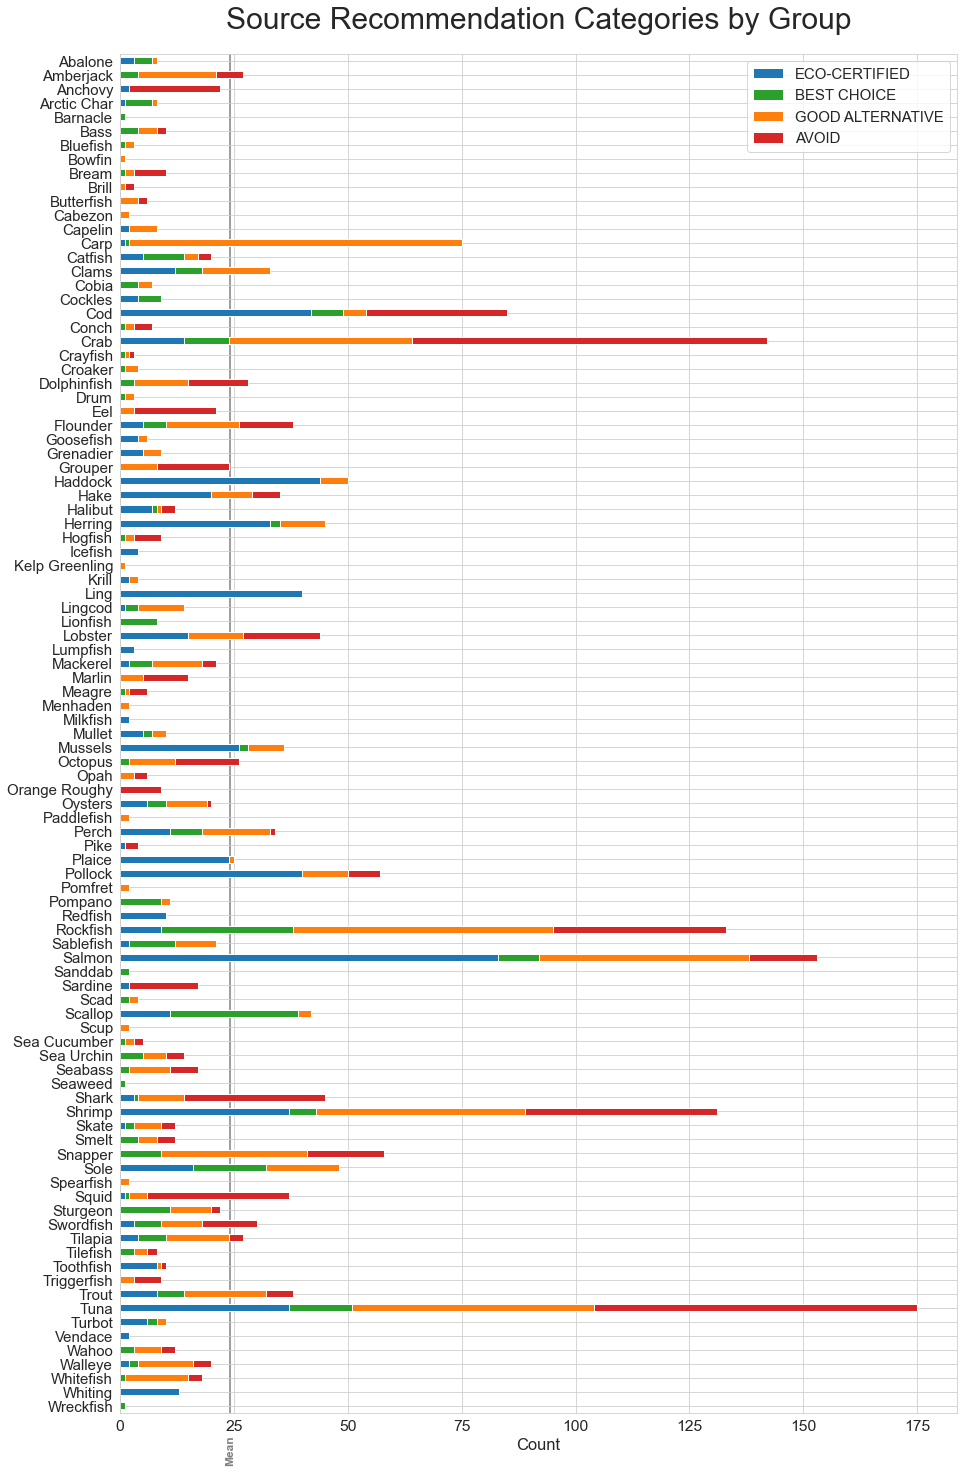

In [70]:
simpleStaBar_df.plot(kind='barh', stacked=True, figsize=(15, 25), color=['tab:blue','tab:green','tab:orange', 'tab:red'])
plt.xlabel('Count')
plt.ylabel('')
plt.title('Source Recommendation Categories by Group')
axvline(x=np.mean(simple_df['numTotal']), color='gray',zorder=0)
text(23, -4.15, "Mean", horizontalalignment='left', size=12, color='gray', weight='semibold', rotation='vertical')


Text(23, -4.15, 'Mean')

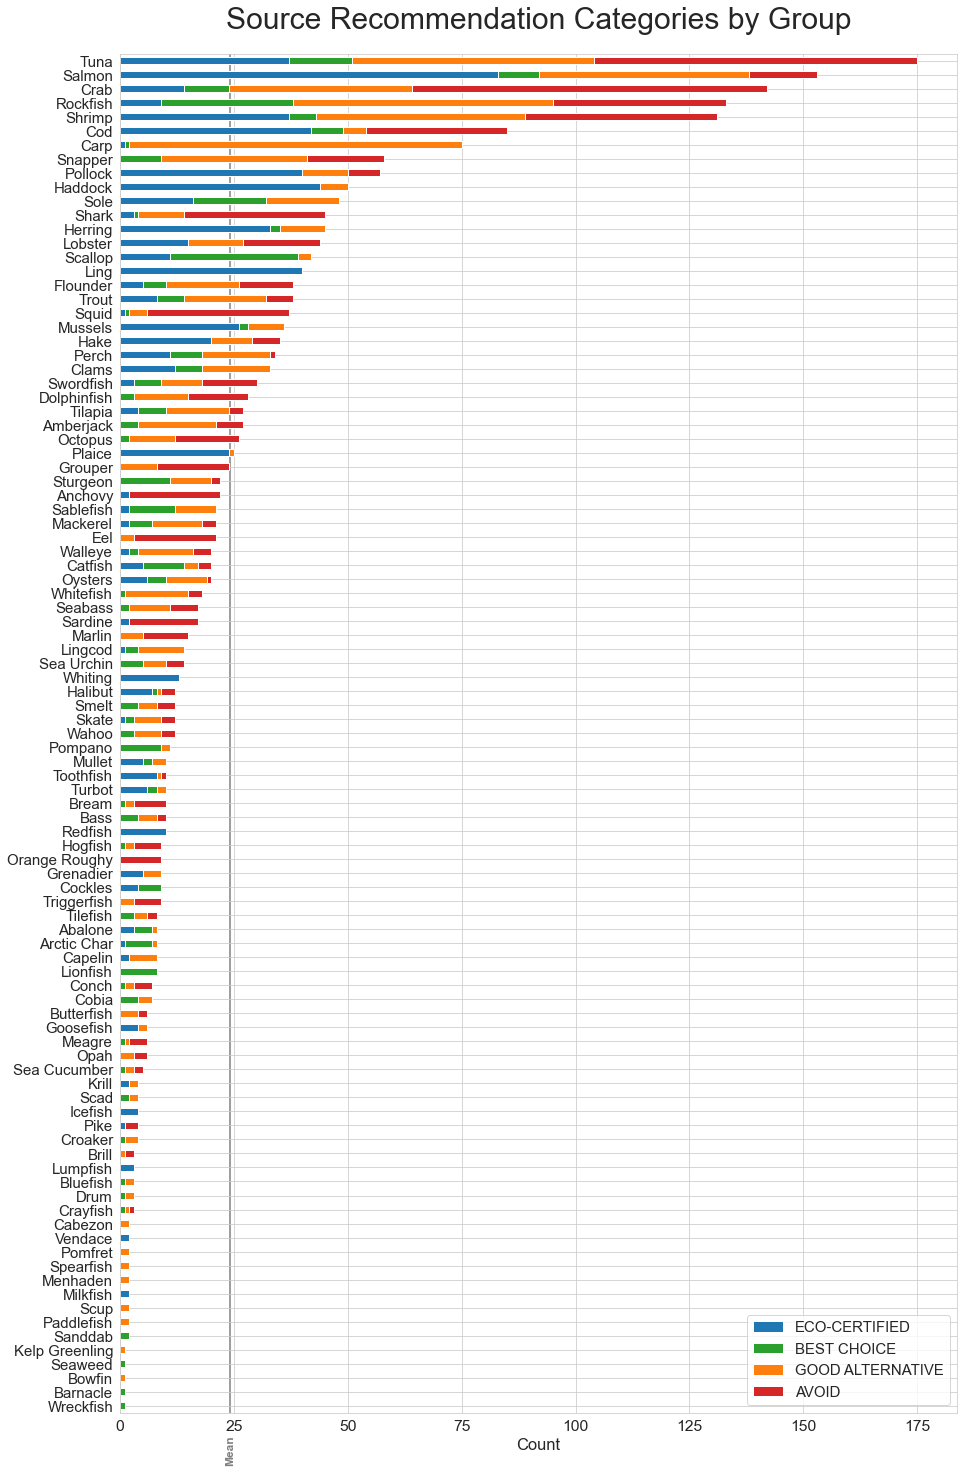

In [71]:
simpleStaBar_df.assign(numTot=simpleStaBar_df.sum(axis=1))
simpleStaBarS_df = simpleStaBar_df.assign(numTot=simpleStaBar_df.sum(axis=1)).sort_values('numTot')
simpleStaBarS_df = simpleStaBarS_df.drop('numTot', 1)
simpleStaBarS_df.plot(kind='barh', stacked=True, figsize=(15, 25), color=['tab:blue','tab:green','tab:orange', 'tab:red'])
plt.xlabel('Count')
plt.ylabel('')
plt.title('Source Recommendation Categories by Group')
axvline(x=np.mean(simple_df['numTotal']), color='gray',zorder=0)
text(23, -4.15, "Mean", horizontalalignment='left', size=12, color='gray', weight='semibold', rotation='vertical')


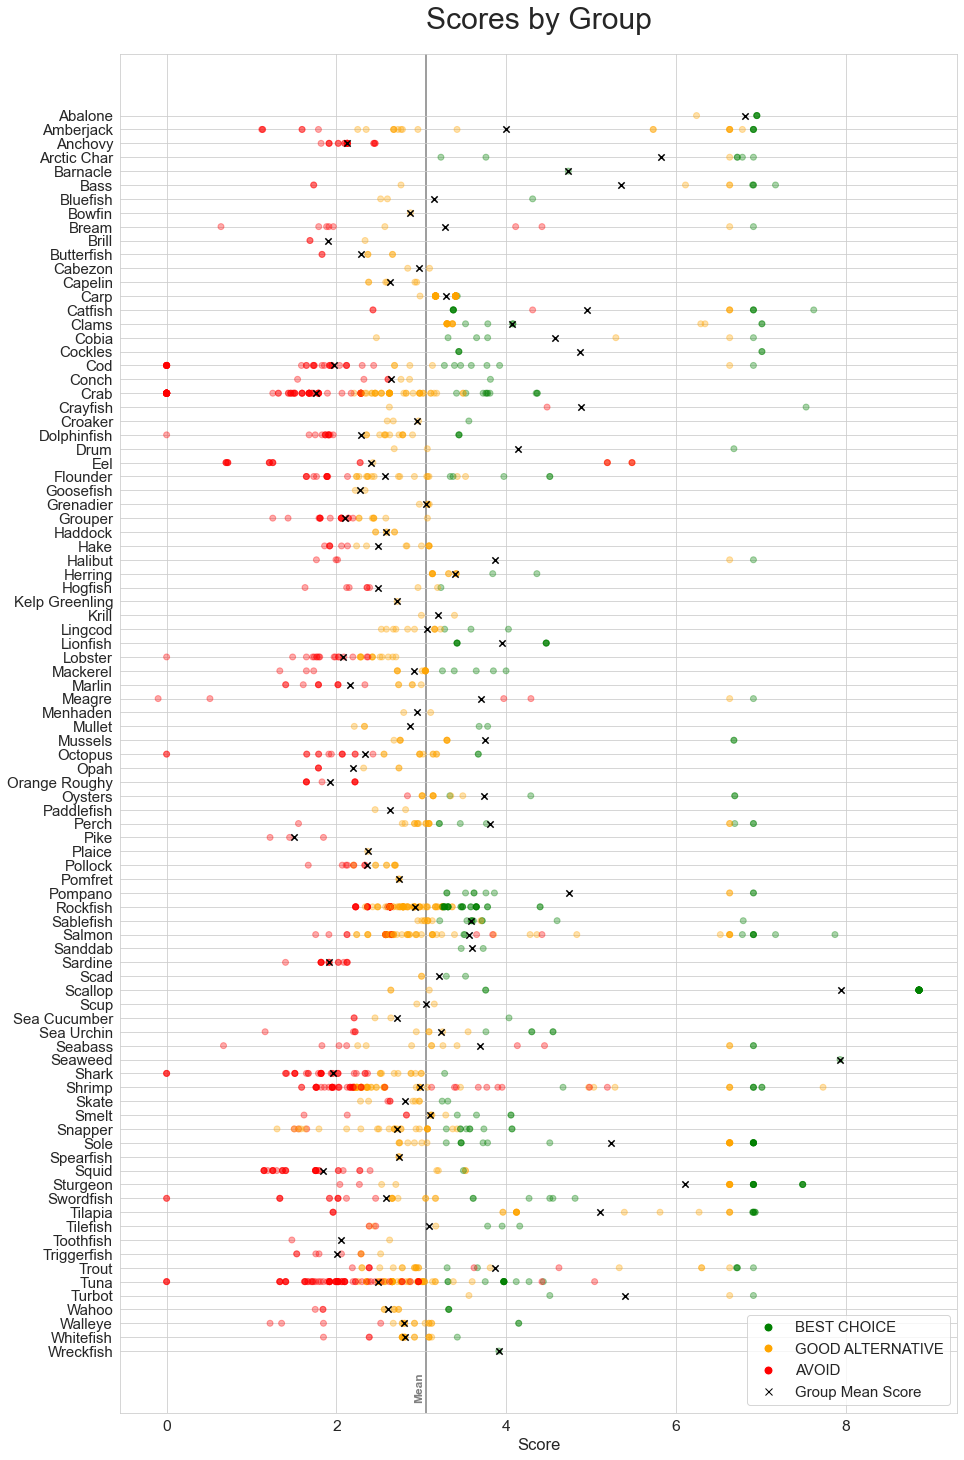

In [72]:
## Scores by groups without ECO-cert.

sortS_detail_df= sortS_detail_df.sort_values('group', ascending = False)
# create list of colors according to recommend column

cols = pltcolor(sortS_detail_df['recommend'] )
grp=sortS_detail_df.groupby('group')
group_grp=[]

for key, values in grp:
    group_grp.append(key)

sns.set_style("whitegrid")
plt.figure(figsize=(15, 25))

plt.xlabel('Score')
#plt.ylabel('Probability')

plt.title('Scores by Group')
p1=plt.scatter(sortS_detail_df['overallScore'], sortS_detail_df['group'], c=cols, alpha=1/3)
p1=plt.scatter(sortS_detail_df.groupby('group').agg({'overallScore':'mean'}), group_grp, c='k', marker='x', label='Mean',s=40)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='BEST CHOICE', markerfacecolor='g', markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='GOOD ALTERNATIVE', markerfacecolor='orange', markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='AVOID', markerfacecolor='r', markersize=9),
                   Line2D([0], [0], marker='x', color='k', label='Group Mean Score', linewidth=0, markersize=7)]

p1=plt.legend(handles= legend_elements, loc= 'lower right')
axvline(x=np.mean([float(x) for x in OverallScore_c]), color='gray',zorder=0)
p1=text(2.92, -3.6, "Mean", horizontalalignment='left', size=12, color='gray', weight='semibold', rotation='vertical')


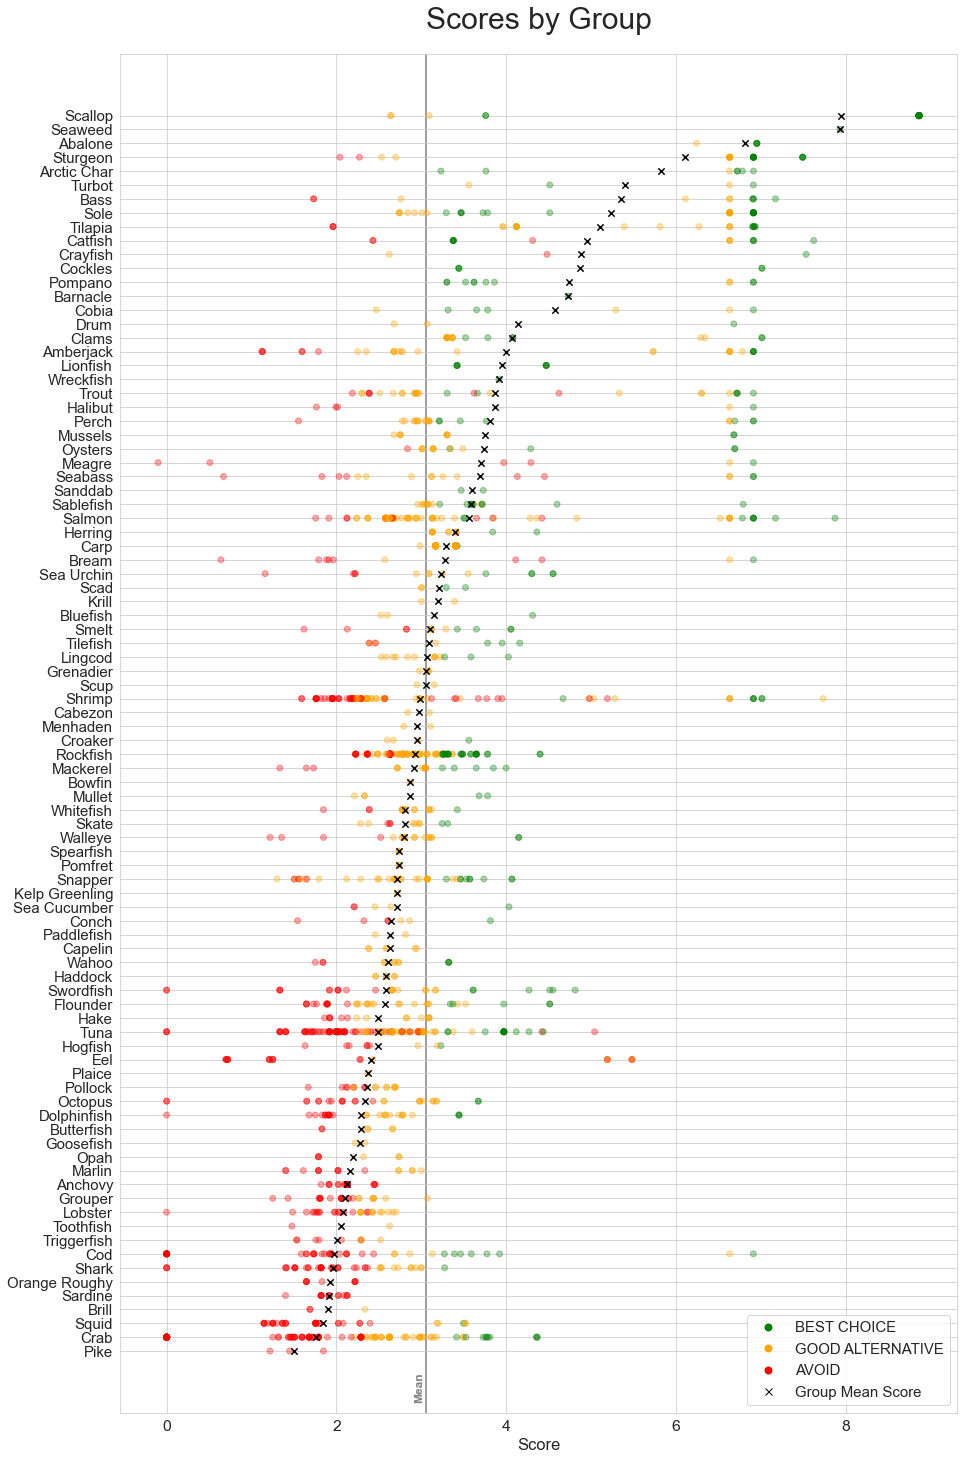

In [73]:
## Scores by groups without ECO cert., same plot as above but with groups sorted by mean score

sortGmean_detail_df= sortS_detail_df.iloc[(sortS_detail_df.groupby('group')['overallScore'].transform('mean')).argsort()]
# create list of colors according to recommend column

cols = pltcolor(sortGmean_detail_df['recommend'] )
# get list of 76 methods ordered above by mean overallScore

grp=sortGmean_detail_df.groupby('group')
group_grp=[]

for key, values in grp:
    group_grp.append(key)

sns.set_style("whitegrid")
plt.figure(figsize=(15, 25))

plt.xlabel('Score')
#plt.ylabel('Probability')

plt.title('Scores by Group')
p1=plt.scatter(sortGmean_detail_df['overallScore'], sortGmean_detail_df['group'], c=cols, alpha=1/3)
p1=plt.scatter(sortGmean_detail_df.groupby('group').agg({'overallScore':'mean'}), group_grp, c='k', marker='x', label='Mean',s=40)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='BEST CHOICE', markerfacecolor='g', markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='GOOD ALTERNATIVE', markerfacecolor='orange', markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='AVOID', markerfacecolor='r', markersize=9),
                   Line2D([0], [0], marker='x', color='k', label='Group Mean Score', linewidth=0, markersize=7)]

p1=plt.legend(handles= legend_elements, loc= 'lower right')
axvline(x=np.mean([float(x) for x in OverallScore_c]), color='gray',zorder=0)
p1=text(2.92, -3.6, "Mean", horizontalalignment='left', size=12, color='gray', weight='semibold', rotation='vertical')
